# SEIRX model runs for contact weight calibration

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import json

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

# custom functionality
from scseirx.model_nursing_home import SEIRX_nursing_home # agent-based simulation
from scseirx import analysis_functions as af # custom analysis functions
import calibration_functions as cf

Contacts of type intermediate and far have a reduced transmission risk as compared to household contacts. In this scenario, the weights that reduce the transmission risk for intermediate and far (in the publication called "loose") contacts are the only two free parameters. Here, we find the values for the intermediate and far contact weights that best fit the empirically observed outbreak data to calibrate the simulation.  

**Note**: Over the course of the calibration it turned out that while the value for the far contact weight does converge, the value for the intermediate contact weight does not show any clear optimum, even for very large ensemble sizes (10000). This is most likely due to the fact that the contacts of type "far" by far outnumber contacts of type "intermediate". Therefore the weight of "intermediate" contacts does not significantly influence the outbreak dynamics in the homes. For the sake of simplicity, we therefore chose to set the intermediate contact weight to equal the far contact weight and calibrate only the far contact weight, wich we simply call "contact weight" in the following script.

## Parameters

Parameters for the calibration simulation are split into "simulation parameters" and "measures", stored in separate JSON files. "Simulation parameters" hold information related to the epidemiological characteristics of the virus (SARS-CoV-2), which are not changed in this study. "Measures" hold information about the measures implemented in the homes at the point in time at which the empirical data, that is used for the calibration, was collected. These measures include
* The mode of testing (diagnostic)
* The test technology used for diagnostic testing (PCR)
* The result turnover time of the test technology (2 days)
* If there was follow-up testing after a positive result (no)
* The types of contacts that were considered to be of "type 1" and that would be quarantined if a positive case with a type 1 contact was detected ("close" and "intermediate")
* The duration of quarantine (10 days)
* Whether or not employees and residents wore masks (they didn't)
* If there was regular room ventilation (there wasn't)

In [2]:
with open('params/calibration_simulation_parameters.json') as json_file:
    simulation_params = json.load(json_file)
    
with open('params/calibration_measures.json') as json_file:
    measures = json.load(json_file)


In [136]:
# paths for data I/O
contact_network_src = '../data/contact_networks'
emp_data_src = '../data/outbreaks'
ensmbl_dst = '../data/calibration_results/ensembles'

# number of days used to compare the simulated and empirical data and
# calculate the error metric. This value is chosen to be the duration
# (in days) of the longest of the observed outbreaks.
comp_period = 27

## Simulation function

In [137]:
def run(param_list):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface and nothing else.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters 
        intermediate_contact_weight and far_contact_weight as well as the 
        number of runs that are passed to the simulation.

    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''

    # extract the simulation parameters from the parameter list: the contact
    # weight is calubrated, N_runs is chosen such that the statistics of the
    # ensembles converge
    contact_weight, N_runs = param_list

    # run the ensemble with the given simulation parameters 
    ensemble_results = cf.run_ensemble(N_runs, contact_weight, measures,
                        simulation_params, contact_network_src, emp_data_src, 
                        comp_period, ensmbl_dst)

    # calculate the ensemble statistics
    row = cf.evaluate_ensemble(ensemble_results, contact_weight)

    return row

## Coarse parameter space screen

First, we do a coarse screen of the full parameter range that makes sense, i.e. contact weights that are zero or above and satisfy contact weight < household contact weight.

The household contact weight is 1 by default. If the contact weight is 0, that means that there are no transmissions possible through a contact of that type (intermediate or far). We screen the weight in increments of 0.1.

### Screening parameters

Coarse grid of parameter values that will be screened:

In [79]:
# the contact weight is the modifier by which the base transmission risk (for
# household transmissions) is multiplied for contacts of type "intermediate" 
# and of type "far"
contact_weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
N_runs_coarse = 1000
screening_params = [(i, N_runs_coarse) for i in contact_weights]

print('there are {} parameter combinations'.format(len(screening_params)))

there are 11 parameter combinations


Each parameter value is simulated for an ensemble of simulation runs. Ensemble statistics are independent of other ensembles, therefore ensembles can be simulated in parallel to save time and use all available cores.

### Run simulations

In [21]:
%%time
# leave 2 cores to do other stuff
number_of_cores = psutil.cpu_count(logical=True) - 2 
pool = Pool(number_of_cores)

rows = []
for row in tqdm(pool.imap_unordered(func=run, iterable=screening_params),
                total=len(screening_params)):
        rows.append(row)
pool.close()

# format and dump the results to disk
dst = '../data/calibration_results'
results = pd.DataFrame()
for row in rows:
    results = results.append(row, ignore_index=True)
    
results.reset_index()
index_cols = ['contact_weight']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst,'calibration_results_coarse_N{}.csv'.format(N_runs)),
               index=False)

100%|██████████| 11/11 [04:43<00:00, 25.79s/it]

CPU times: user 119 ms, sys: 103 ms, total: 223 ms
Wall time: 4min 43s


### Assess results

Find the combination of intermediate and far contact weights that minimizes the distance to the empirically observed outbreak characteristics.

In [119]:
results = pd.read_csv(join(dst,'calibration_results_coarse_N{}.csv'.format(N_runs_coarse)))
results['infected_employee_distance_total_mean'] = \
    results[['infected_employee_distance_outbreak_{}_mean'.format(i) for i in range(1, 5)]].mean(axis=1)
results['infected_employee_distance_total_std'] = \
    results[['infected_employee_distance_outbreak_{}_mean'.format(i) for i in range(1, 5)]].std(axis=1)

results['infected_resident_distance_total_mean'] = \
    results[['infected_resident_distance_outbreak_{}_mean'.format(i) for i in range(1, 5)]].mean(axis=1)
results['infected_resident_distance_total_std'] = \
    results[['infected_resident_distance_outbreak_{}_mean'.format(i) for i in range(1, 5)]].std(axis=1)

results['distance_total'] = results['infected_employee_distance_total_mean'] +\
                            results['infected_resident_distance_total_mean']
results['distance_total_std'] = np.sqrt(results['infected_employee_distance_total_std']**2 + \
                                        results['infected_resident_distance_total_std'] **2)

best_weight = results.loc[\
    results['distance_total'].idxmin()]['contact_weight']

print('best contact weight: {}'.format(best_weight))

best contact weight: 0.1


### Visualize error terms

To get a better understanding of the error term landscape, we visualize the different contributions (employee, resident) to the total error term:

In [120]:
results = results.set_index(['contact_weight'])

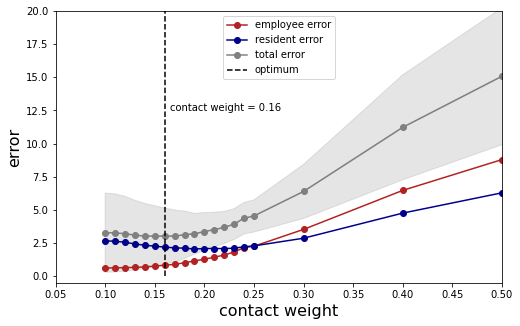

In [197]:
fig, ax = plt.subplots(figsize=(8, 5))
cf.plot_errors(ax, results, best_weight, xmin=0.05)

## Fine parameter space screen

### Screening parameters

Starting from the best parameter value found in the coarse sampling, we sample a finer grid of parameter values in the neighbourhood of the optimal value determined in the coarse scan. Here, we sample parameter values in increments of 0.01.

In [84]:
contact_weights = [0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17,
                    0.18, 0.19, 0.21, 0.22, 0.23, 0.24, 0.25]

# the ensemble size is increased to reduce variance around the ensemble error
# metric means
N_runs_fine = 5000

screening_params = [(i, N_runs_fine) for i in contact_weights]

print('there are {} parameter combinations'.format(len(screening_params)))

there are 14 parameter combinations


### Run simulations

In [57]:
%%time
number_of_cores = psutil.cpu_count(logical=True) - 2 
pool = Pool(number_of_cores)

rows = []
for row in tqdm(pool.imap_unordered(func=run, iterable=screening_params),
                total=len(screening_params)):
        rows.append(row)
pool.close()

dst = '../data/calibration_results'
results = pd.DataFrame()
for row in rows:
    results = results.append(row, ignore_index=True)
    
results.reset_index()
index_cols = ['contact_weight']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst,'calibration_results_fine_N{}.csv'.format(N_runs)),
               index=False)

100%|██████████| 14/14 [23:12<00:00, 99.46s/it]  

CPU times: user 229 ms, sys: 137 ms, total: 366 ms
Wall time: 23min 12s


### Assess results

In [123]:
dst = '../data/calibration_results'

results1 = pd.read_csv(join(dst,'calibration_results_fine_N{}.csv'.format(N_runs_fine)))
results2 = pd.read_csv(join(dst,'calibration_results_coarse_N{}.csv'.format(N_runs_coarse)))
results = pd.concat([results1, results2])
results = results.sort_values(by='contact_weight')
results = results.reset_index(drop=True)

results['infected_employee_distance_total_mean'] = \
    results[['infected_employee_distance_outbreak_{}_mean'.format(i) for i in range(1, 5)]].mean(axis=1)
results['infected_employee_distance_total_std'] = \
    results[['infected_employee_distance_outbreak_{}_mean'.format(i) for i in range(1, 5)]].std(axis=1)

results['infected_resident_distance_total_mean'] = \
    results[['infected_resident_distance_outbreak_{}_mean'.format(i) for i in range(1, 5)]].mean(axis=1)
results['infected_resident_distance_total_std'] = \
    results[['infected_resident_distance_outbreak_{}_mean'.format(i) for i in range(1, 5)]].std(axis=1)

results['distance_total'] = results['infected_employee_distance_total_mean'] +\
                            results['infected_resident_distance_total_mean']
results['distance_total_std'] = np.sqrt(results['infected_employee_distance_total_std']**2 + \
                                        results['infected_resident_distance_total_std'] **2)

best_weight = results.loc[\
    results['distance_total'].idxmin()]['contact_weight']

print('best contact weight: {}'.format(best_weight))

best contact weight: 0.16


### Visualize error terms

In [124]:
results = results.set_index(['contact_weight'])

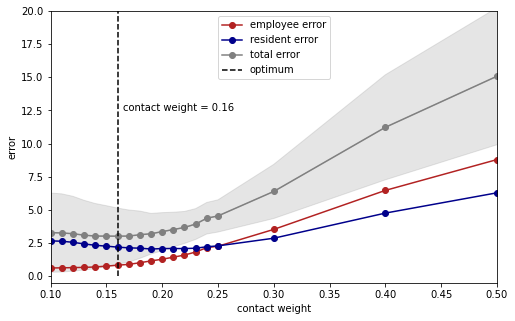

In [125]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_errors(ax, results, best_weight)